In [1]:
import numpy as np
import numpy.matlib as ml
import scipy.stats as stats
import matplotlib.pyplot as plt
import csv
import pandas as pd
from sklearn.utils import resample
import seaborn as sns


In [2]:
sns.set_theme(style="darkgrid")
sns.color_palette("viridis", as_cmap=True)
title_font = {
    'fontname': 'DejaVu Sans', 'size': '15', 'color': 'black',
    'weight': 'medium'
}
axis_font = {'fontname': 'DejaVu Sans', 'size': '15', 'color': 'black'}

In [3]:
import os
import FUNC_Stable3_GasSphere_ElasticShellViscFlesh as vefunc

# Fixed Parameters
Most parameters are fixed for Limacina

In [52]:
M_order=2

ro1=1027    # Surronding Water density  "kg/m³"
ro2=1040  # Surronding viscouis layer (fish flesh) density  "kg/m³" 
ro3=2920  # Elastic sphere Density "kg/m³"  # Hard aragonite shell
ro4= 1050 # Inner Gas Sphere Density "kg/m³" internal tissue (MacLennan and Simmonds 2005) g agrees with Lavery 2007. g=1.022

c1=1479    # Surronding Water speed of sound "m/s" @ 4,3deg 31,2 PSU
c2=1523    # Surronding viscouis layer (fish flesh) speed of sound "m/s"
#c3=1480    # Elastic sphere speed of sound "m/s"
c4=c2    # gas speed of sound "m/s" As fish flesh, internal tissue (MacLennan and Simmonds 2005) agrees with Lavery 2007 

Eta2=2*0.428572
Mu2=Eta2
Kisi2=Mu2+4*Eta2/3
    
Mu3=35800*1.0E6  # "N/m²" shear rigidity of elastic shell aragonite sheer modulus
Landa3=2.4*1E9  # "N/m²" Compressional rigidity of elastic shell

c3=(ro3/(Landa3+2*Mu3))**-0.5    # Elastic sphere speed of sound "m/s"


In [53]:
# calculate g and h for inside radius
g4 = ro4/ro1
h4 = c4/c1
print('sound speed contrast h='+str(h4)+' and density contrast g='+str(g4))

sound speed contrast h=1.0297498309668696 and density contrast g=1.0223953261927945


In [54]:
# set fixed values
params_lima ={'ro1':ro1,
            'ro2':ro2,
            'ro3':ro3,
            'ro4':ro4,
            'c1':c1,
            'c2':c2,
            'c3':c3,
            'c4':c4,
            'Eta2':Eta2,
            'Mu3':Mu3,
            'Landa3':Landa3,
            'Kisi2':Kisi2}

## Variable Parameters
For these model simulations the only variable with distribution is the **SHAPE.**

The main variable parameter is R3- the radius of the swimbladder including the wall. In the case of Limacina it is the whole measured length (or calculated width).

The other two variable parameters are R4- radius of the swimbladder (R3-thickness of swimbladder wall) and R2-radius of fish fesh, since there is not flesh around the shell in a Limacina, we use R4=R3.

0.1999999999737716


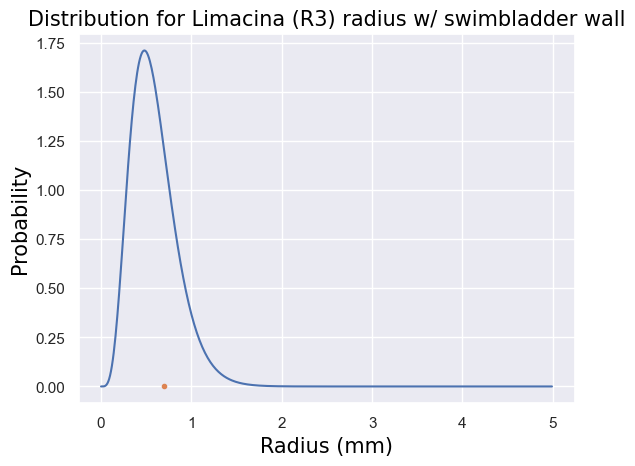

In [55]:
# Radius R3 distribution
# Values from lengthDist.Rmd. scale is 1/rate. shape is alpha. 
# radius distribution was calculated using all measured lengths (divided by 2!) and their associated widths(Divided by 2!) (L/a=1.5 Stanton 2000)
x=np.arange(0,5,0.01)
R3_dist = stats.gamma.pdf(x,a=5.4,scale=1/9.17)
print(R3_dist.mean())

plt.plot(x,R3_dist)
plt.plot(0.7,0, '.')
plt.title('Distribution for Limacina (R3) radius w/ swimbladder wall', title_font)
plt.xlabel('Radius (mm)', axis_font)
plt.ylabel('Probability', axis_font);

## Set up simulation

In [65]:
# Frequency range
min_freq=1*1000
max_freq=1000*1000
frequencySpacing=100
Freq_vec=np.arange(min_freq,max_freq,frequencySpacing) 

## Run once

In [66]:
nsim = 1
nfreqs = len(Freq_vec)
ind_sim =0
# Allocate space for speed
R3 = np.zeros((nsim,1))
R4 = np.zeros((nsim,1))
TS_simulations = np.zeros((nsim*nfreqs))
freqs=np.zeros((nsim*nfreqs))

    
# Set new radius parameters
R3 = 1.5*1e-3
params_lima['R3'] = R3
params_lima['R2'] = R3
params_lima['R4'] = R3  - (R3*0.023) 

# Run the v-e model
print('Running simulations for SB radius %.2f mm, simulation %.0f' %(R3*1000,ind_sim))
TS_vec_lima = vefunc.run_ve(Freq_vec, M_order, params_lima)

# Save each iterated radius values
params_lima['R4']

# Save all results.
TS_simulations[ind_sim*nfreqs:ind_sim*nfreqs+nfreqs] = TS_vec_lima
freqs[ind_sim*nfreqs:ind_sim*nfreqs+nfreqs] = Freq_vec

Running simulations for SB radius 1.50 mm, simulation 0


## Create dataframe for results

In [67]:

ve_simdata=pd.DataFrame({'freqs':freqs/1000,'TS_lima':TS_simulations, 'R3 (mm)': R3*1000})

# Plot results
Colour is used to indicated the effect of shape (Limacina radius at the angle of incidence) on the frequency response.

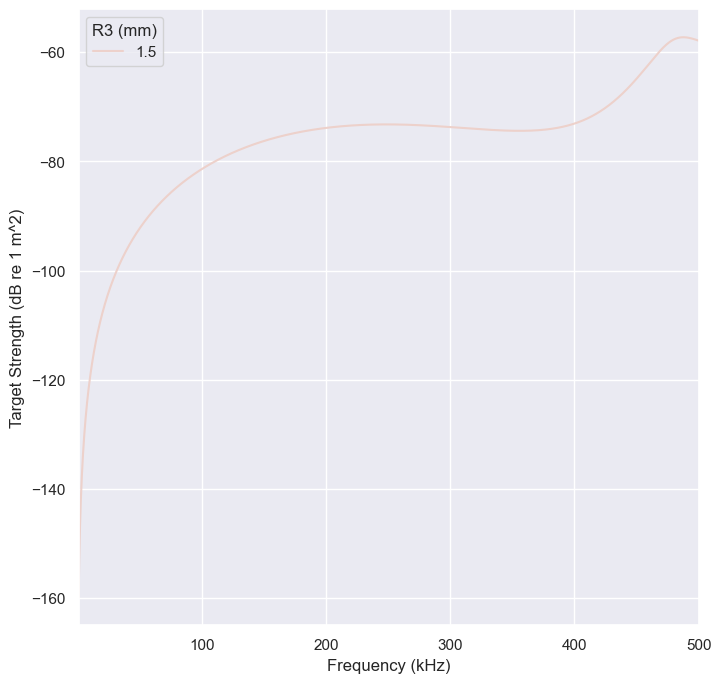

In [68]:
plt.figure(figsize=(8,8))
sns.lineplot(data=ve_simdata, x='freqs',y='TS_lima',hue='R3 (mm)')
plt.ylabel('Target Strength (dB re 1 m^2)')
plt.xlabel('Frequency (kHz)')
plt.xlim([1, 500]);

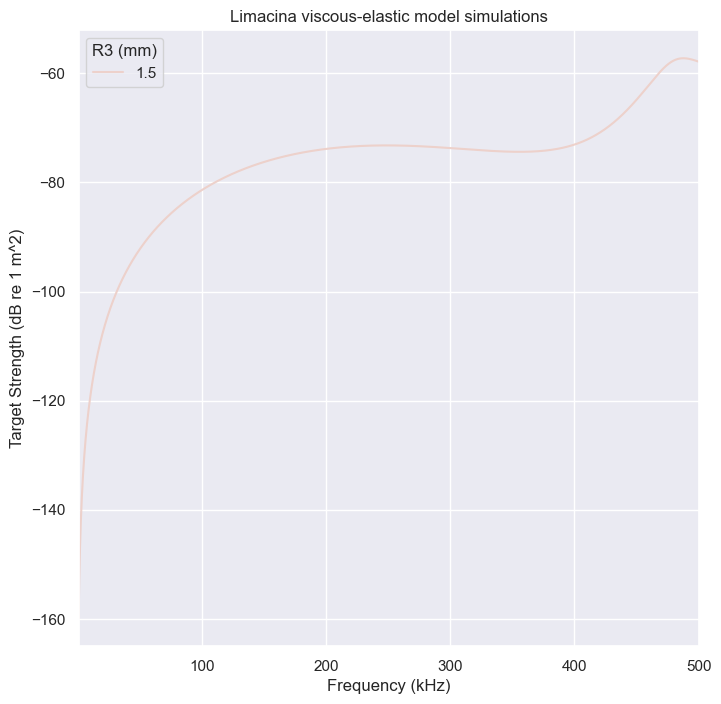

In [69]:
plt.figure(figsize=(8,8))
sns.lineplot(data=ve_simdata, x='freqs',y='TS_lima',hue='R3 (mm)')
plt.ylabel('Target Strength (dB re 1 m^2)')
plt.xlabel('Frequency (kHz)')
plt.title('Limacina viscous-elastic model simulations')
plt.xlim([1, 500]);

# Put it all in a matrix

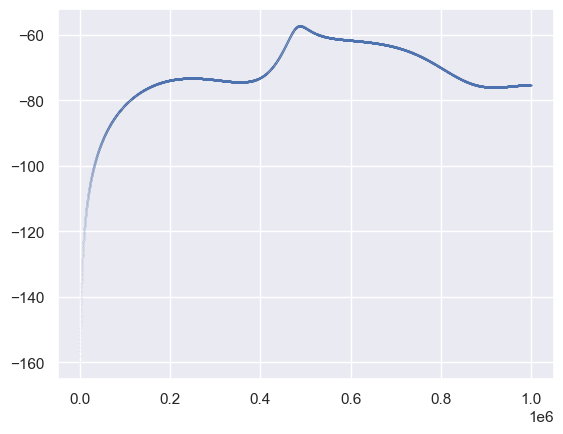

In [70]:
F_TS_MAT=np.concatenate((freqs.reshape(-1,1),TS_simulations.reshape(-1,1)),axis=1)
plt.plot(F_TS_MAT[:,0],F_TS_MAT[:,1], '.', markersize=0.1)

## Write to file
Write the results in a text file with a header of parameters and a row for each frequency and TS.

Should I add R3?

In [71]:
# uncomment when ready.
vefunc.write_ve('./ve_results/ve_limacina_28092023.txt', M_order, params_lima, F_TS_MAT)

In [72]:
ve_simdata['sigbs'] = 10**(ve_simdata['TS_lima']/10)
mean_bs = ve_simdata.groupby(["freqs"]).agg({'sigbs':'mean'})

Text(0.5, 1.0, 'Limacina')

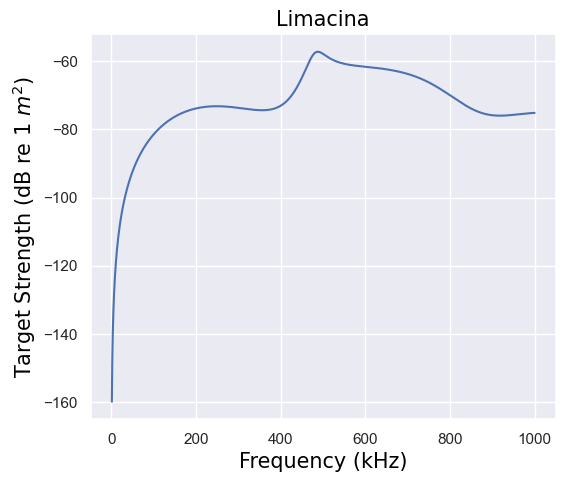

In [73]:
plt.figure(figsize=(6,5))
sns.lineplot(data=ve_simdata, x='freqs',y='TS_lima')
plt.ylabel('Target Strength (dB re 1 $m^2$)', axis_font)
plt.xlabel('Frequency (kHz)', axis_font)
plt.title('Limacina', title_font)

(282.0, 383.0)

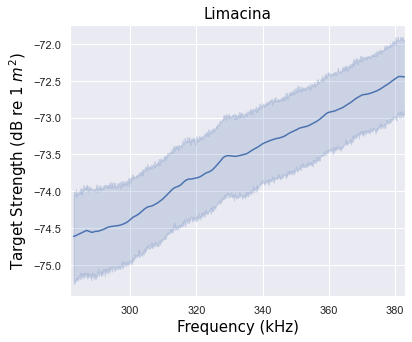

In [41]:
plt.figure(figsize=(6,5))
sns.lineplot(data=ve_simdata, x='freqs',y='TS_lima')
plt.ylabel('Target Strength (dB re 1 $m^2$)', axis_font)
plt.xlabel('Frequency (kHz)', axis_font)
plt.title('Limacina', title_font)
plt.xlim([282,383])

In [42]:
# k = 2pi/lambda = 2pi*f/c
ve_simdata['ka'] = (R3_simulations*1e-3)*2*np.pi*freqs/1480

In [43]:
middle_ka = np.mean(R3_simulations*1e-3)*2*np.pi*333000/1480

Text(0.5, 1.0, 'Limacina')

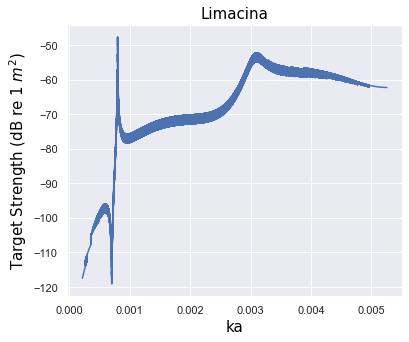

In [44]:
plt.figure(figsize=(6,5))
sns.lineplot(data=ve_simdata, x='ka',y='TS_lima')
#plt.plot([middle_ka, middle_ka],[-140, -40])
plt.ylabel('Target Strength (dB re 1 $m^2$)', axis_font)
plt.xlabel('ka', axis_font)
plt.title('Limacina', title_font)

# CI boot

In [45]:
simulations=ve_simdata
n_boots=100
percentiles=(2.5, 97.5)
# First, calculate mean for each frequency of the whole sample
mean_bs = simulations.groupby(['freqs']).mean()['sigbs']


# Resample , calculate mean repeat n_boot times, then calculate the SPREAD of the MEANS.
sigbs = simulations.sigbs
freq = simulations.freqs
freqs = np.unique(freq)

# Create our empty array to fill the results
ci_boot = np.zeros([2, len(freqs)])

# Resample over each frequency
for i in range(len(freqs)):
    sigbs_selectfreq = sigbs[freq==freqs[i]]

    # Create our empty array to fill the results              
    bootstrap_means = np.zeros([n_boots])

    # Resample within the values of the selected frequency and calculate the mean
    for ii in range(n_boots):
    # Generate random indices for our data *with* replacement, then take the sample mean
        random_sample = resample(sigbs_selectfreq)
        bootstrap_means[ii] = random_sample.mean(axis=0)

    # Save the percentiles of the bootstraped means for the selected frequency
    ci_boot[:,i] = np.percentile(bootstrap_means, percentiles, axis=0)

Text(0.5, 1.0, 'Limacina')

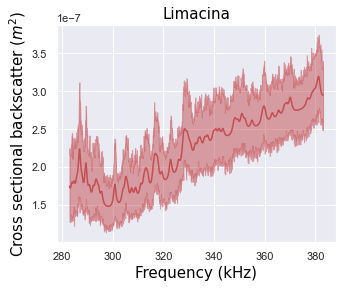

In [46]:
plt.figure(figsize=(5,4))
plt.plot(freqs, mean_bs, 'r')
plt.fill_between(freqs, ci_boot[0,:], ci_boot[1,:], alpha=0.5, color='r')
plt.ylabel('Cross sectional backscatter ($m^{2}$)', axis_font)
plt.xlabel('Frequency (kHz)', axis_font)
plt.title('Limacina', title_font)